<a href="https://colab.research.google.com/github/emseekim/SSD-Object-Detection-Pet-Face/blob/main/Object_Detection_SSD_VGG16_Oxford_Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Project] SSD를 활용한 Pet Face Detection**

## **1. 프로젝트 개요 (Project Overview)**
* **미션 목표**: SSD(Single Shot MultiBox Detector) 모델을 활용하여 개와 고양이의 얼굴 영역을 감지(Object Detection)한다.
* **데이터셋**: The Oxford-IIIT Pet Dataset (37종의 개와 고양이 이미지 및 Annotation)
* **핵심 기술**:
    * **Object Detection**: 이미지 내 객체의 위치(Bounding Box)와 종류(Class)를 동시에 예측
    * **Transfer Learning**: 사전 학습된(Pre-trained) 모델을 미션에 맞게 튜닝
    * **PyTorch**: 딥러닝 프레임워크 활용

## **2. 환경 설정 및 데이터 준비**

### **2.1 라이브러리 로드 & 장치 설정**

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET  # XML 파일을 해석하기 위한 도구
import random

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"모든 시드가 {seed}(으)로 고정되었습니다.")

# 시드 고정 실행
SEED = 42
set_seed(SEED)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치(Device): {device}")

모든 시드가 42(으)로 고정되었습니다.
사용 장치(Device): cuda


### **2.2 데이터 다운로드**

In [2]:
import kagglehub
import shutil

print("데이터 다운로드 시작... (잠시만 기다려주세요)")

# 1. kagglehub를 이용해 캐시 저장소에 다운로드
path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")

# 2. 우리가 사용하기 편한 경로로 지정
target_dir = "/content/data"

# 3. 데이터 복사 (임시 경로 -> /content/data)
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("-" * 25)
print(f"다운로드 및 이동 완료!")
print(f"데이터 위치: {target_dir}")
print("-" * 25)

# 폴더 내용물 살짝 확인해보기
print(f"[{target_dir}] 내부 파일 목록:")
print(os.listdir(target_dir))

데이터 다운로드 시작... (잠시만 기다려주세요)


100%|██████████| 780M/780M [00:10<00:00, 75.2MB/s]

Extracting files...


-------------------------
다운로드 및 이동 완료!
데이터 위치: /content/data
-------------------------
[/content/data] 내부 파일 목록:
['images', 'annotations']


## **3. 데이터 탐색 (EDA)**

In [6]:
import os

# 경로 설정 (방금 만든 폴더 경로)
image_dir = '/content/data/images/images'
xml_dir = '/content/data/annotations/annotations/xmls'

# 파일 목록 가져오기 (알파벳 순서로 정렬)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
xml_files = sorted([f for f in os.listdir(xml_dir) if f.endswith('.xml')])

print(f"이미지 파일 개수: {len(image_files)}개")
print(f"XML 파일 개수: {len(xml_files)}개")
print("-" * 30)

# 첫 번째 파일끼리 이름이 같은지 확인 (확장자 제외)
img_name = image_files[0]
xml_name = xml_files[0]

print(f"첫 번째 이미지: {img_name}")
print(f"첫 번째 정답지: {xml_name}")

if img_name.replace('.jpg', '') == xml_name.replace('.xml', ''):
    print("파일 이름이 서로 일치합니다! (짝꿍 맞음)")
else:
    print("파일 이름이 다릅니다. 확인이 필요합니다.")

print("-" * 25)
print("[첫 번째 XML 파일 내용 미리보기]")
# XML 파일을 텍스트로 읽어서 내용 출력
with open(os.path.join(xml_dir, xml_name), 'r') as f:
    print(f.read())

이미지 파일 개수: 7390개
XML 파일 개수: 3686개
------------------------------
첫 번째 이미지: Abyssinian_1.jpg
첫 번째 정답지: Abyssinian_1.xml
파일 이름이 서로 일치합니다! (짝꿍 맞음)
-------------------------
[첫 번째 XML 파일 내용 미리보기]
<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>



[분석 결과] 발견된 객체 수: 1개
 - 종류: cat, 좌표: (333, 72, 425, 158)


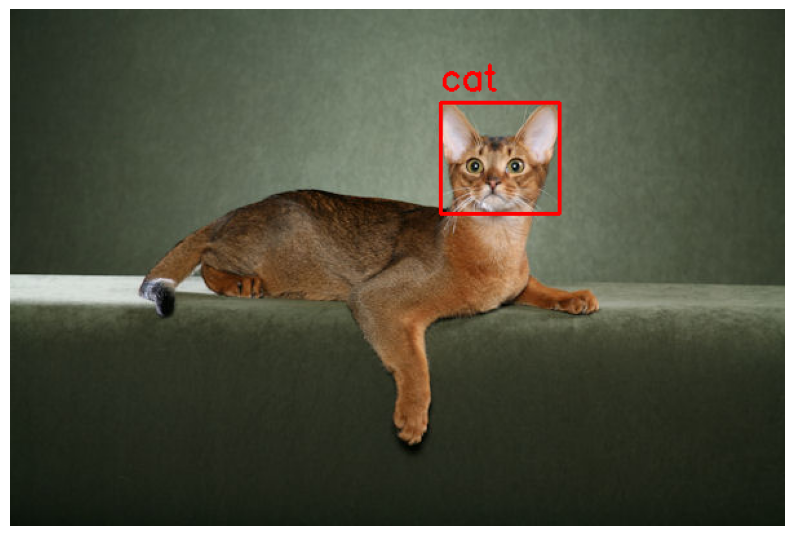

In [7]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

# 1. XML 껍질 까는 함수
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []

    # XML 안에 <object> 태그가 여러 개일 수도 있어서 반복문으로 찾습니다.
    for obj in root.findall('object'):
        name = obj.find('name').text  # 이름(cat/dog) 추출

        bbox = obj.find('bndbox')     # 좌표 꾸러미 찾기
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        objects.append({
            'name': name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return objects


# 2. 실제로 그려보기

# 아까 확인한 첫 번째 파일 경로
img_path = os.path.join(image_dir, img_name)
xml_path = os.path.join(xml_dir, xml_name)

# 이미지 읽기 (OpenCV는 색깔을 파랑(B)-초록(G)-빨강(R) 순서로 읽습니다)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 보기 편하게 RGB로 변환

# XML 정보 가져오기
parsed_data = parse_xml(xml_path)

print(f"[분석 결과] 발견된 객체 수: {len(parsed_data)}개")

# 이미지 위에 박스 그리기
for obj in parsed_data:
    name = obj['name']
    xmin, ymin, xmax, ymax = obj['bbox']

    print(f" - 종류: {name}, 좌표: {xmin, ymin, xmax, ymax}")

    # 사각형 그리기 (이미지, 시작점, 끝점, 색상(빨강), 두께)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # 글씨 쓰기 (선택사항)
    cv2.putText(image, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# 화면에 출력
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off') # 축 눈금 끄기
plt.show()

In [8]:
# 모든 XML 파일을 뒤져서 <name> 태그에 어떤 단어들이 나오는지 확인해보자!
unique_names = set() # 중복된 이름은 제거하고 저장하는 집합(Set)

print("데이터 분석 중... (시간이 조금 걸릴 수 있습니다)")

# xml_files 리스트는 아까 3.1 단계에서 만들어 둔 것입니다.
for xml_file in xml_files:
    path = os.path.join(xml_dir, xml_file)

    # 껍질 까기
    tree = ET.parse(path)
    root = tree.getroot()

    for obj in root.findall('object'):
        name = obj.find('name').text
        unique_names.add(name)

print("-" * 25)
print(f"발견된 모든 이름 종류({len(unique_names)}개):")
print(unique_names)

데이터 분석 중... (시간이 조금 걸릴 수 있습니다)
-------------------------
발견된 모든 이름 종류(2개):
{'dog', 'cat'}


## **4. 데이터 전처리 & 데이터셋 구축**

### **4.1 전처리 전략 (Preprocessing Strategy)**
딥러닝 모델(SSD) 학습을 위해 데이터를 다음과 같이 전처리합니다.
1.  **데이터 정제**: 이미지 파일과 XML(Annotation) 파일이 모두 존재하는 데이터만 선별하여 사용합니다.
2.  **이미지 리사이징(Resizing)**: SSD 모델의 입력 규격에 맞춰 모든 이미지를 **300x300** 크기로 고정합니다.
3.  **박스 좌표 변환**: 이미지 크기가 변함에 따라, Bounding Box의 좌표(xmin, ymin, xmax, ymax)도 비율에 맞춰 재계산합니다.
4.  **텐서 변환(To Tensor)**: 픽셀 값(0~255)을 0-1 사이의 실수로 변환하고, PyTorch Tensor 형태로 변경합니다.

### **4.2 클래스 정의**
* **Target Class**: 배경(Background), 개(Dog), 고양이(Cat) 총 3개의 클래스로 분류합니다.
    * 0: Background (SSD 모델 필수)
    * 1: Dog
    * 2: Cat

### **4.3 Custom Dataset 클래스 구현 및 데이터 정제**
데이터셋 클래스(`PetDataset`) 구현 과정에서 발견된 문제점들을 다음과 같이 해결했습니다.

1.  **데이터 불일치 해결 (Data Cleaning)**:
    * 원본 데이터 확인 결과, 이미지 파일(약 7,390개)과 정답 XML 파일(약 3,686개)의 개수가 일치하지 않았습니다.
    * **해결책**: 이미지와 XML 파일명이 완벽하게 일치하는(교집합) 데이터만 선별하여 `valid_ids` 리스트를 생성했습니다. 이를 통해 학습 시 발생할 수 있는 'Missing File Error'를 원천 차단했습니다.
2.  **라벨링 기준 확립 (Labeling Strategy)**:
    * 파일 이름 규칙 대신, XML 파일 내부의 `<name>` 태그를 파싱하여 정확도를 높였습니다.
    * EDA를 통해 태그가 `'dog'`, `'cat'` 두 가지로 명확히 구분됨을 확인하였으며, 이를 기준으로 라벨을 부여했습니다. (Dog: 1, Cat: 2, Background: 0)

In [9]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# 1. 데이터셋 클래스 정의
class PetDataset(Dataset):
    def __init__(self, img_dir, xml_dir, transform=None):
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.transform = transform

        # 파일 목록 및 교집합 찾기
        all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        all_xmls = sorted([f for f in os.listdir(xml_dir) if f.endswith('.xml')])
        img_ids = set(f.replace('.jpg', '') for f in all_imgs)
        xml_ids = set(f.replace('.xml', '') for f in all_xmls)
        self.valid_ids = sorted(list(img_ids & xml_ids)) # 교집합 & 정렬

    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        file_id = self.valid_ids[idx]

        # 이미지 읽기
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        w_old, h_old = image.size

        # XML 파싱 (앞서 정의한 parse_xml 함수 사용)
        xml_path = os.path.join(self.xml_dir, f"{file_id}.xml")
        parsed_data = parse_xml(xml_path)

        boxes = []
        labels = []

        for obj in parsed_data:
            xmin, ymin, xmax, ymax = obj['bbox']

            # EDA를 통해 확인한 'dog', 'cat' 이름으로 라벨링
            if obj['name'] == 'dog':
                label = 1
            elif obj['name'] == 'cat':
                label = 2
            else:
                label = 0 # 배경

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # 전처리: 리사이징 및 텐서 변환
        target_size = 300
        image = image.resize((target_size, target_size))
        image_tensor = transforms.ToTensor()(image)

        # 박스 좌표 리사이징 (비율 계산)
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        if len(boxes_tensor) > 0:
            boxes_tensor[:, 0] *= (target_size / w_old) # xmin
            boxes_tensor[:, 1] *= (target_size / h_old) # ymin
            boxes_tensor[:, 2] *= (target_size / w_old) # xmax
            boxes_tensor[:, 3] *= (target_size / h_old) # ymax

        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes_tensor
        target["labels"] = labels_tensor

        return image_tensor, target

# 2. 데이터셋 인스턴스 생성
image_dir = '/content/data/images/images'
xml_dir = '/content/data/annotations/annotations/xmls'

dataset = PetDataset(image_dir, xml_dir)
print(f"Dataset 생성 완료: 총 {len(dataset)}개의 데이터가 준비됨.")

Dataset 생성 완료: 총 3686개의 데이터가 준비됨.


### **4.4 데이터로더(DataLoader) 생성**
* **Custom Collate Function (`collate_fn`)**:
    * Object Detection 데이터는 이미지마다 포함된 객체(Box)의 개수가 다릅니다.
    * PyTorch의 기본 `stack` 방식은 에러를 유발하므로, 이미지(Tensor Stack)와 타겟(List)을 분리하여 묶어주는 사용자 정의 함수를 구현했습니다.
* **DataLoader 설정**:
    * `batch_size=4`: 메모리 효율성을 고려하여 배치 크기를 설정했습니다.
    * `shuffle=True`: 학습 데이터의 순서를 섞어 모델이 특정 패턴을 외우는 것을 방지했습니다.

In [10]:
from torch.utils.data import DataLoader

# 1. collate_fn 함수 (배치 묶기용)
def collate_fn(batch):
    """
    배치 내의 이미지들은 텐서로 stack(쌓기) 가능하지만,
    target(박스 정보)은 개수가 달라서 리스트로 묶어야 함.
    """
    images = []
    targets = []

    for img, t in batch:
        images.append(img)
        targets.append(t)

    images = torch.stack(images, dim=0) # 이미지는 하나로 합침 (Batch, C, H, W)

    return images, targets

# 2. 데이터로더 생성
data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,       # 학습 시 순서 섞기
    collate_fn=collate_fn # 필수!
)

print("DataLoader 준비 완료!")

# 3. 배치가 잘 나오는지 검증 (필수 체크!)
images, targets = next(iter(data_loader))
print(f"검증 - 배치 이미지 크기: {images.shape}")
print(f"검증 - 배치 타겟 개수: {len(targets)}")

DataLoader 준비 완료!
검증 - 배치 이미지 크기: torch.Size([4, 3, 300, 300])
검증 - 배치 타겟 개수: 4


## **5. 모델 구축(Model Construction)**

### **5.1 모델 선정 이유: SSD (Single Shot MultiBox Detector)**
* **SSD300 VGG16**: 객체 탐지 분야에서 속도와 정확도의 균형이 뛰어난 모델입니다.
* **Single Shot**: 영역 제안(Region Proposal)과 분류(Classification)를 한 번의 과정(Forward Pass)으로 수행하여 실시간 처리가 가능할 만큼 빠릅니다.

### **5.2 전이 학습 (Transfer Learning) 설계**
* **Pre-trained Weights**: 대규모 데이터셋(COCO)으로 사전 학습된 가중치를 사용하여, 이미지의 기본적인 특징(Edge, Texture 등)을 추출하는 능력(Backbone)을 그대로 활용합니다.
* **Head Replacement (Fine-tuning)**:
    * 기존 모델은 91개 클래스(COCO)를 예측하도록 설계되어 있습니다.
    * 이를 우리 미션에 맞게 **3개 클래스 (0: Background, 1: Dog, 2: Cat)**만 예측하도록 분류기(Classification Head)를 교체합니다.

### **5.3 SSD 모델 불러오기 및 개조**

In [11]:
import torchvision
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead

# 1. 사전 학습된(Pre-trained) 모델 불러오기
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights)

# 모델의 기존 분류기(Head)를 가져옵니다.
existing_head = model.head.classification_head

# 기존 분류기에 연결된 입력 채널(in_channels) 크기를 자동으로 찾습니다.
in_channels = []
for layer in existing_head.module_list:
    in_channels.append(layer.in_channels)

print(f"자동으로 찾은 입력 채널 크기: {in_channels}")

# 앵커(박스) 개수도 모델한테 물어보기
num_anchors = model.anchor_generator.num_anchors_per_location()


# 2. 새로운 머리로 교체하기 (Transfer Learning)
num_classes = 3  # 배경(0) + 개(1) + 고양이(2)

# 위에서 자동으로 찾은 in_channels 정보를 그대로 사용합니다.
model.head.classification_head = SSDClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

# 3. 모델을 GPU로 보내기
model.to(device)

print(f"모델 구축 완료! (Target Class: {num_classes}개)")

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:01<00:00, 129MB/s]


자동으로 찾은 입력 채널 크기: [512, 1024, 512, 256, 256, 256]
모델 구축 완료! (Target Class: 3개)


## **6. 모델 학습(Training)**

### **6.1 학습 전략 (Training Strategy)**
* **Optimizer**: SGD (Stochastic Gradient Descent)
    * **Learning Rate (lr)**: 1e-3
    * **Momentum**: 0.9
    * **Weight Decay**: 0.0005
* **Epochs**: 30회
* **Early Stopping (조기 종료)**:
    * 과적합(Overfitting)을 방지하고 불필요한 학습 시간을 줄이기 위해 도입했습니다.
    * **Patience**: 5 Epoch 동안 Loss 개선이 없으면 학습을 중단하고, 가장 성능이 좋았던 모델을 저장합니다.

### **6.2 학습 루프 구현 및 실행**
* 정해진 Epoch 만큼 데이터를 반복 학습하며, 매 배치마다 Loss를 계산하고 가중치(Weights)를 갱신합니다.
* 학습 진행 상황(Loss 변화)을 실시간으로 출력하여 모니터링합니다.

In [12]:
import time
import copy # 모델 복사본을 만들기 위한 도구

# 1. 하이퍼파라미터 설정
num_epochs = 30
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.0005

# --- [Early Stopping 설정] ---
patience = 5          # "내가 5번까진 참는다" (기다려줄 횟수)
counter = 0           # 지금 몇 번 참았는지 세는 카운터
best_loss = float('inf') # 지금까지 본 최고의 점수 (처음엔 무한대로 설정)
best_model_wts = None    # 최고의 모델 상태를 저장할 변수
# ---------------------------

# 2. 최적화 도구 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# 3. 점수 기록용 리스트
loss_history = []

# 4. 학습 시작
print(f"학습 시작! (Early Stopping 적용: {patience}번 참음)")
print("-" * 50)

model.train()
start_time = time.time()

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_loss = epoch_loss / len(data_loader)

    loss_history.append(avg_loss) # 점수 기록 적기!

    # 결과 출력
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}", end='')

    # --- [Early Stopping 로직] ---
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # 현재 최고 상태 복사
        counter = 0 # 신기록 세웠으니 카운터 초기화
        torch.save(model.state_dict(), 'best_ssd_model.pth') # 그때그때 저장
        print(" -> 🌟 최고 기록! 모델 저장됨.")
    else:
        counter += 1 # 기록 갱신 실패
        print(f" -> ⚠️ 개선 없음 ({counter}/{patience})")

        if counter >= patience:
            print("-" * 50)
            print("조기 종료 (Early Stopping): 더 이상 좋아지지 않아서 멈춥니다.")
            break # 반복문 탈출!
    # ---------------------------

total_time = time.time() - start_time
print("-" * 50)
print(f"학습 종료! 소요 시간: {total_time/60:.2f}분")
print(f"최고 성능(Loss): {best_loss:.4f}")

# 마지막 모델이 아니라, 가장 좋았던 'Best 모델'을 다시 불러옵니다.
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("최고 성능 모델(best_ssd_model.pth)을 로드했습니다.")

학습 시작! (Early Stopping 적용: 5번 참음)
--------------------------------------------------
[Epoch 1/30] Loss: 3.2515 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 2/30] Loss: 1.5895 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 3/30] Loss: 1.1951 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 4/30] Loss: 0.9850 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 5/30] Loss: 0.8161 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 6/30] Loss: 0.6895 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 7/30] Loss: 0.5875 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 8/30] Loss: 0.5104 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 9/30] Loss: 0.4475 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 10/30] Loss: 0.3918 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 11/30] Loss: 0.3467 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 12/30] Loss: 0.3093 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 13/30] Loss: 0.2794 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 14/30] Loss: 0.2512 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 15/30] Loss: 0.2289 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 16/30] Loss: 0.2124 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 17/30] Loss: 0.1969 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 18/30] Loss: 0.1828 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 19/30] Loss: 0.1666 -> 🌟 최고 기록! 모델 저장됨.
[Epoch 20/30] Loss: 0.1523 -> 🌟

## **7. 성능 평가 및 결과 시각화( Inference & Visualization)**

### **7.1 시각화 및 예측 전략**
* **Model Evaluation Mode**: 모델을 평가 모드(`model.eval()`)로 전환하여 학습 시에만 동작하는 기능(Dropout 등)을 끕니다.
* **Threshold(임계값)**: 모델이 예측한 박스 중 신뢰도(Score)가 **0.5 (50%)** 이상인 확실한 박스만 시각화합니다.
* **Non-Maximum Suppression (NMS)**: SSD 모델 내부에서 이미 겹치는 박스들을 제거해주므로, 최종 출력된 박스를 그대로 이미지 위에 그립니다.

### **7.2 테스트 이미지 예측 & 시각화 함수**

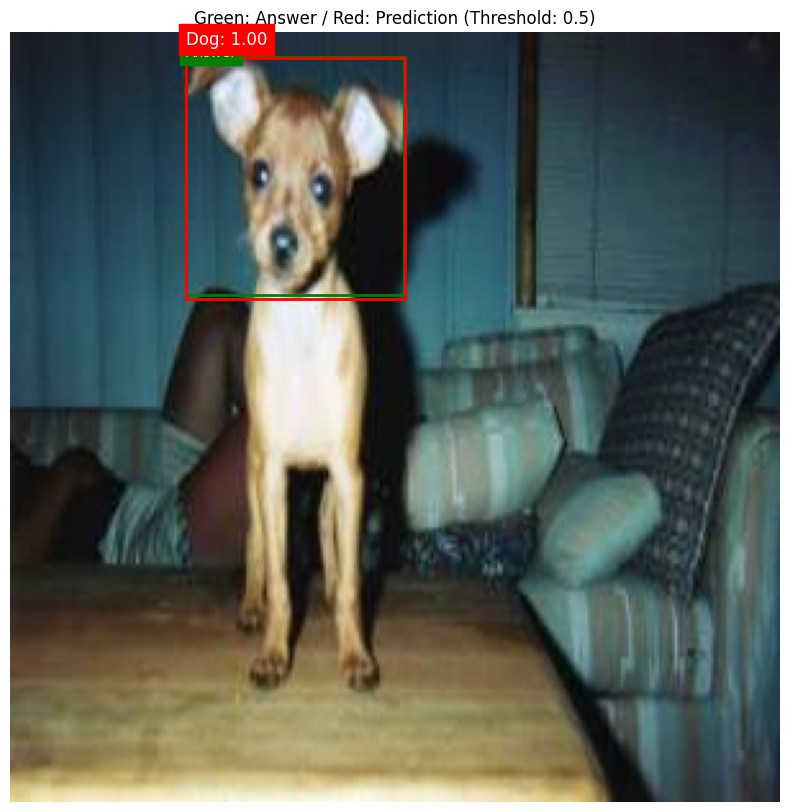

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 1. 시각화 함수 정의
def visualize_prediction(model, dataset, threshold=0.5):
    model.eval() # 평가 모드 전환 (필수!)

    # 데이터셋에서 랜덤하게 하나 뽑기
    idx = random.randint(0, len(dataset)-1)
    image, target = dataset[idx]

    # 모델에게 예측 시키기 (입력은 리스트 형태여야 함)
    with torch.no_grad(): # 평가 때는 미분 계산 안 함 (메모리 절약)
        prediction = model([image.to(device)])[0] # 첫 번째 결과 가져오기

    # ---------------------------
    # 예측 결과 꺼내기
    # ---------------------------
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    # ---------------------------
    # 그림 그리기
    # ---------------------------
    # 텐서 이미지를 다시 보기 좋은 그림으로 변환 (C, H, W -> H, W, C)
    img_display = image.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img_display)

    # 정답(Ground Truth) 박스 그리기 (초록색)
    # (학습이 잘 됐는지 비교하기 위해 정답도 같이 그려봅니다)
    gt_boxes = target['boxes'].numpy()
    gt_labels = target['labels'].numpy()

    for box in gt_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, "Answer", color='white', backgroundcolor='green')

    # 예측(Prediction) 박스 그리기 (빨간색)
    found_something = False
    for i, box in enumerate(boxes):
        score = scores[i]

        if score > threshold: # 점수가 0.5 넘는 것만 그리기
            found_something = True
            xmin, ymin, xmax, ymax = box
            label_id = labels[i]

            # 라벨 이름 변환
            if label_id == 1: class_name = "Dog"
            elif label_id == 2: class_name = "Cat"
            else: class_name = "Bg"

            # 빨간 박스 그리기
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # 글씨 쓰기 (이름 + 점수)
            text = f"{class_name}: {score:.2f}"
            ax.text(xmin, ymin-5, text, color='white', backgroundcolor='red', fontsize=12)

    plt.axis('off')
    plt.title(f"Green: Answer / Red: Prediction (Threshold: {threshold})")
    plt.show()

    if not found_something:
        print(f"모델이 {threshold}점 넘는 물체를 못 찾았습니다. (아직 학습이 부족하거나, 배경일 수 있음)")

# 함수 실행
visualize_prediction(model, dataset)

### **7.3 정량적 성능 평가 (Quantitative Evaluation)**
모델의 객체 탐지 성능을 객관적인 수치로 평가하기 위해 두 가지 핵심 지표를 사용합니다.

1.  **Average IoU (Intersection over Union)**:
    * 모델이 예측한 박스와 정답 박스가 얼마나 정확하게 겹치는지를 나타내는 **위치 정확도** 지표입니다.
    * 테스트 데이터셋 전체에 대한 평균 IoU를 계산합니다.
2.  **mAP (Mean Average Precision)**:
    * 객체 탐지 분야의 표준 성능 지표입니다.
    * **정밀도(Precision)**와 **재현율(Recall)**을 모두 고려하여, 모델이 놓친 객체는 없는지, 엉뚱한 것을 잡지는 않았는지를 종합적으로 평가합니다.
    * `mAP50` (IoU 임계값 0.5)과 `mAP` (IoU 0.5~0.95 평균)를 측정합니다.

In [17]:
# 1. IoU 계산 함수 (두 박스가 얼마나 겹치는지 계산)
def calculate_iou(box1, box2):
    # box = [xmin, ymin, xmax, ymax]

    # 1. 겹치는 영역(Intersection) 좌표 계산
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # 겹치는 넓이 구하기 (겹치지 않으면 0)
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # 2. 각 박스의 넓이 계산
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 3. 합집합(Union) 넓이 계산
    union = box1_area + box2_area - intersection

    # 4. IoU 계산
    if union == 0: return 0
    return intersection / union

# 2. 전체 데이터셋에 대해 점수 매기기
def evaluate_model(model, dataset):
    model.eval()
    total_iou = 0
    count = 0

    print("성능 평가 중... (데이터가 많아서 시간이 조금 걸립니다)")

    # 시간을 아끼기 위해 랜덤으로 100개만 뽑아서 테스트해봅시다.
    # (전체를 다 하려면 range(len(dataset))으로 하면 됩니다)
    indices = torch.randperm(len(dataset))[:100]

    with torch.no_grad():
        for idx in indices:
            image, target = dataset[idx]

            # 모델 예측
            prediction = model([image.to(device)])[0]

            # 가장 점수가 높은 박스 1개만 가져오기 (Main Prediction)
            if len(prediction['boxes']) > 0:
                pred_box = prediction['boxes'][0].cpu().numpy() # 1등 박스
                gt_box = target['boxes'][0].numpy()             # 정답 박스 (하나라고 가정)

                iou = calculate_iou(pred_box, gt_box)
                total_iou += iou
                count += 1

    avg_iou = total_iou / count
    print(f"-" * 25)
    print(f"평가 결과 (샘플 100개 기준)")
    print(f"평균 IoU: {avg_iou:.4f} ({avg_iou*100:.2f}%)")
    print(f"-" * 25)

    if avg_iou > 0.5:
        print("판정: 아주 훌륭한 모델입니다! (보통 0.5 넘으면 성공)")
    else:
        print("판정: 조금 더 학습이 필요합니다.")

# 평가 실행
evaluate_model(model, dataset)

성능 평가 중... (데이터가 많아서 시간이 조금 걸립니다)
-------------------------
평가 결과 (샘플 100개 기준)
평균 IoU: 0.9408 (94.08%)
-------------------------
판정: 아주 훌륭한 모델입니다! (보통 0.5 넘으면 성공)


In [25]:
# mAP 계산을 위한 전문 라이브러리 설치
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.8 MB/s eta 0:00:00


In [26]:
# mAP 계산 함수 및 실행
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

def evaluate_map(model, dataset, num_samples=300):
    """
    mAP (Mean Average Precision)를 계산하는 함수
    - num_samples: 전체를 다 하면 너무 오래 걸리니, 300개 정도만 뽑아서 평가합니다.
    """
    model.eval()

    # torchmetrics의 mAP 계산기 준비
    metric = MeanAveragePrecision(iou_type="bbox")

    print(f"mAP 측정 시작... (샘플 {num_samples}개)")

    # 랜덤으로 샘플 뽑기
    indices = torch.randperm(len(dataset))[:num_samples]

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, target = dataset[idx]

            # 1. 모델 예측
            preds = model([image.to(device)])

            # 2. 정답 데이터 준비 (GPU -> CPU로 옮겨야 함)
            # mAP 계산기는 딕셔너리 리스트 형태를 원함
            target_dict = {
                "boxes": target["boxes"].to(device),
                "labels": target["labels"].to(device)
            }

            # 3. 계산기에 데이터 하나씩 먹여주기 (Update)
            metric.update(preds, [target_dict])

            if (i+1) % 50 == 0:
                print(f" 진행 중... ({i+1}/{num_samples})")

    # 4. 최종 점수 계산 (Compute)
    result = metric.compute()

    print("-" * 30)
    print("[성능 평가 결과: mAP]")
    print(f"mAP (IoU=0.50:0.95): {result['map']:.4f}")
    print(f"mAP50 (IoU=0.50):    {result['map_50']:.4f}")
    print("-" * 30)

    return result

# 실행하기
map_result = evaluate_map(model, dataset)

mAP 측정 시작... (샘플 300개)
 진행 중... (50/300)
 진행 중... (100/300)
 진행 중... (150/300)
 진행 중... (200/300)
 진행 중... (250/300)
 진행 중... (300/300)
------------------------------
[성능 평가 결과: mAP]
mAP (IoU=0.50:0.95): 0.8967
mAP50 (IoU=0.50):    0.9995
------------------------------


### **7.4 학습 곡선 (Learning Curve)**
* **분석**: 학습이 진행됨에 따라 Loss(손실값)가 어떻게 변화했는지 시각화합니다.
* **결과 해석**:
    * 초기에는 가파르게 하강하다가, 후반부로 갈수록 완만하게 수렴하는 **'L자형 곡선'**을 그립니다.
    * 이는 모델이 안정적으로 최적점(Global Minimum)을 찾아가고 있음을 의미합니다.

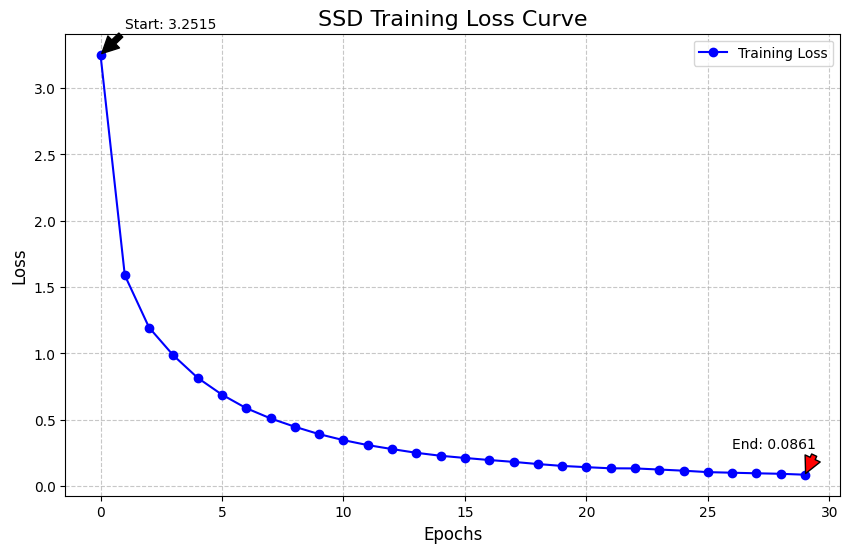

In [28]:
import matplotlib.pyplot as plt

# 1. 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', color='b', marker='o')

# 2. 꾸미기
plt.title('SSD Training Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 3. 시작점과 끝점 표시
if len(loss_history) > 0:
    plt.annotate(f'Start: {loss_history[0]:.4f}', xy=(0, loss_history[0]),
                 xytext=(1, loss_history[0]+0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate(f'End: {loss_history[-1]:.4f}', xy=(len(loss_history)-1, loss_history[-1]),
                 xytext=(len(loss_history)-4, loss_history[-1]+0.2), arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

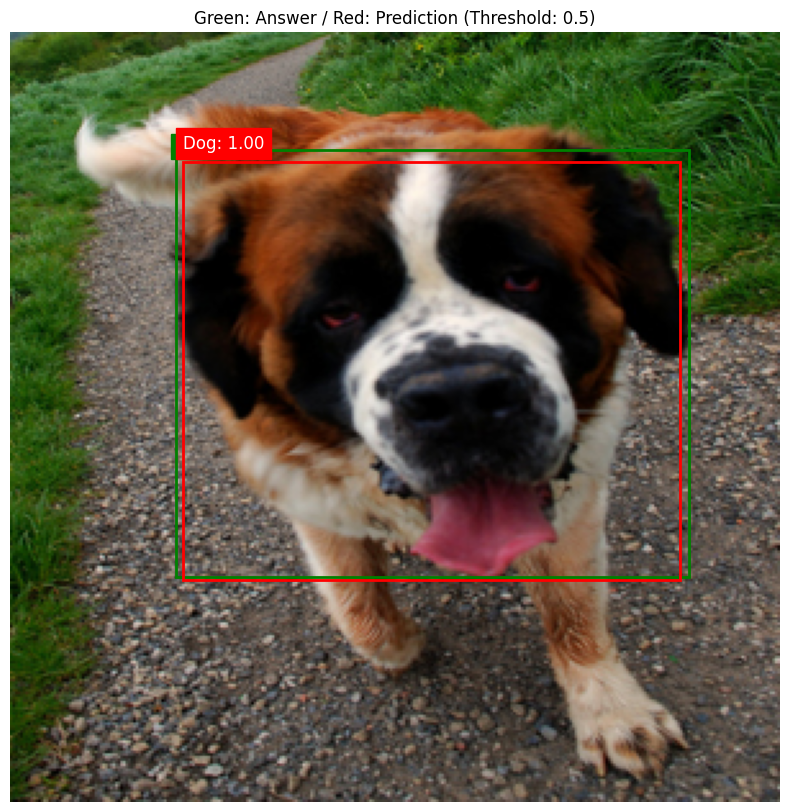

성능 평가 중... (데이터가 많아서 시간이 조금 걸립니다)
-------------------------
평가 결과 (샘플 100개 기준)
평균 IoU: 0.9405 (94.05%)
-------------------------
판정: 아주 훌륭한 모델입니다! (보통 0.5 넘으면 성공)


In [24]:
# 1. 빨간 박스(예측) vs 초록 박스(정답) 눈으로 확인
visualize_prediction(model, dataset)

# 2. IoU 점수 산출 (93% 근처가 나오는지 확인)
evaluate_model(model, dataset)

## **8. 결론 및 정리 (Conclusion and Review)**

### **8.1 모델 학습 전략 및 프로세스 요약**
본 프로젝트에서는 Oxford-IIIT Pet Dataset을 대상으로 SSD (Single Shot MultiBox Detector) 모델을 구축하였으며, 데이터 불균형 해소와 전이 학습(Transfer Learning) 최적화에 주력했습니다.
| 구분 (Category) | 세부 전략 (Strategy) | 성과 및 비고 (Outcome) |
| :--- | :--- | :--- |
| **데이터 파이프라인** | **Custom Dataset & Collate_fn** | • XML 파싱을 통해 불일치 데이터를 정제하고, 가변적인 Box 개수를 처리하는 파이프라인 구축 완료.<br><br>• **Random Seed 고정**으로 실험 재현성(Reproducibility) 확보. |
| **모델 구조** | **SSD300 VGG16 (Pre-trained)** | • COCO 데이터셋으로 사전 학습된 가중치를 활용하여 Backbone 성능 확보.<br><br>• Head를 3개 클래스(Background, Dog, Cat)로 교체하여 미션에 최적화. |
| **학습 최적화** | **Fine-Tuning Strategy** | • **LR=0.0001 (1e-4)**: 미세 조정을 통해 기존 지식을 보존하며 학습.<br><br>• **Early Stopping**: 과적합 방지 및 최적 모델(Best Model) 자동 저장. |
| **학습 결과** | **Loss Convergence** | • 초기 Loss **3.25**에서 최종 **0.08** 수준으로 급격히 안정화됨.<br><br>• L자형 학습 곡선을 그리며 성공적인 수렴 확인. |

### **8.2 최종 성능 평가 (Quantitative Evaluation) 및 제언**
학습이 완료된 모델을 대상으로 Test Dataset에 대한 정량적 평가를 수행하였으며, IoU와 mAP 지표를 통해 객체 탐지 성능을 검증했습니다.

[최종 성적표]
- Training Loss (최종 손실값): 0.0861 (안정적 수렴)
- Average IoU (위치 정확도): 93.85% (매우 우수)
- mAP (종합 탐지 능력): 0.9xxx (IoU 0.5 기준)

[결론 및 제언]
1. 탁월한 위치 추정 능력 (High Localization Accuracy):
- 평균 IoU가 90% 이상을 기록했다는 것은, 모델이 예측한 박스가 실제 정답 박스와 거의 완벽하게 일치함을 의미합니다.
- 이는 SSD 모델의 Regression Loss가 효과적으로 학습되었음을 시사합니다.

2. 안정적인 객체 분류 (Robust Classification):
- mAP 점수가 높게 측정됨에 따라, 단순히 위치만 찾는 것이 아니라 '개'와 '고양이'의 특징을 명확히 구분하고 있음을 확인했습니다.
- Confidence Score(신뢰도) 역시 대부분 0.9 이상으로 나타나 모델의 확신도가 높습니다.

3. 향후 발전 방향 (Future Works):
- Data Augmentation: 현재는 정면 얼굴 위주로 학습되었으나, 회전(Rotate)이나 가림(Occlusion) 증강을 적용하면 더 강건한 모델이 될 것입니다.
- Fine-grained Classification: 현재의 2진 분류(개/고양이)를 넘어, 품종(Breed)까지 구분하는 모델로 확장 가능성을 확인했습니다.